In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import re
from statsmodels.graphics.mosaicplot import mosaic
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('mcdonalds.csv')

In [3]:
data.columns

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [4]:
data.shape

(1453, 15)

In [5]:
data.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [6]:
MD_x = data.iloc[:,0:11].replace("Yes",1).replace("No",0)
col_means = round(MD_x.mean(axis=0), 2)
col_means

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

In [7]:
pca = PCA()
MD_pca = pca.fit_transform(MD_x)
Standard_deviation = np.sqrt(pca.explained_variance_)
Proportion_of_Variance = pca.explained_variance_ratio_
Cumulative_Proportion = np.cumsum(Proportion_of_Variance)
pca_summary_df = pd.DataFrame(
    {
        'Standard deviation': Standard_deviation.round(4),
        'Proportion of Variance': Proportion_of_Variance.round(4),
        'Cumulative Proportion': Cumulative_Proportion.round(4)
    },
    index=[f'PCA{i}' for i in range(1,12)]
)
print("Importance of components:")
pca_summary_df.T

Importance of components:


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11
Standard deviation,0.7570,0.6075,0.5046,0.3988,0.3374,0.3103,0.2897,0.2751,0.2653,0.2488,0.2369
Proportion of Variance,0.2994,0.1928,0.1330,0.0831,0.0595,0.0503,0.0438,0.0395,0.0368,0.0324,0.0293
Cumulative Proportion,0.2994,0.4922,0.6253,0.7084,0.7679,0.8182,0.8620,0.9016,0.9383,0.9707,1.0000


In [8]:
print("Standard deviations (1, .., p=11):")
list(Standard_deviation.round(1))

Standard deviations (1, .., p=11):


[0.8, 0.6, 0.5, 0.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2]

In [9]:
df = pd.DataFrame(pca.components_.T,columns=[f'PCA{i}' for i in range(1,12)],index=data.columns[:11])
print("Rotation (n x k) = (11 x 11):")
df.round(3)

Rotation (n x k) = (11 x 11):


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11
yummy,-0.477,0.364,-0.304,0.055,-0.308,0.171,-0.281,0.013,0.572,-0.110,0.045
convenient,-0.155,0.016,-0.063,-0.142,0.278,-0.348,-0.060,-0.113,-0.018,-0.666,-0.542
spicy,-0.006,0.019,-0.037,0.198,0.071,-0.355,0.708,0.376,0.400,-0.076,0.142
fattening,0.116,-0.034,-0.322,-0.354,-0.073,-0.407,-0.386,0.590,-0.161,-0.005,0.251
greasy,0.304,-0.064,-0.802,0.254,0.361,0.209,0.036,-0.138,-0.003,0.009,0.002
fast,-0.108,-0.087,-0.065,-0.097,0.108,-0.595,-0.087,-0.628,0.166,0.240,0.339
cheap,-0.337,-0.611,-0.149,0.119,-0.129,-0.103,-0.040,0.140,0.076,0.428,-0.489
tasty,-0.472,0.307,-0.287,-0.003,-0.211,-0.077,0.360,-0.073,-0.639,0.079,0.020
expensive,0.329,0.601,0.024,0.068,-0.003,-0.261,-0.068,0.030,0.067,0.454,-0.490
healthy,-0.214,0.077,0.192,0.763,0.288,-0.178,-0.350,0.176,-0.186,-0.038,0.158


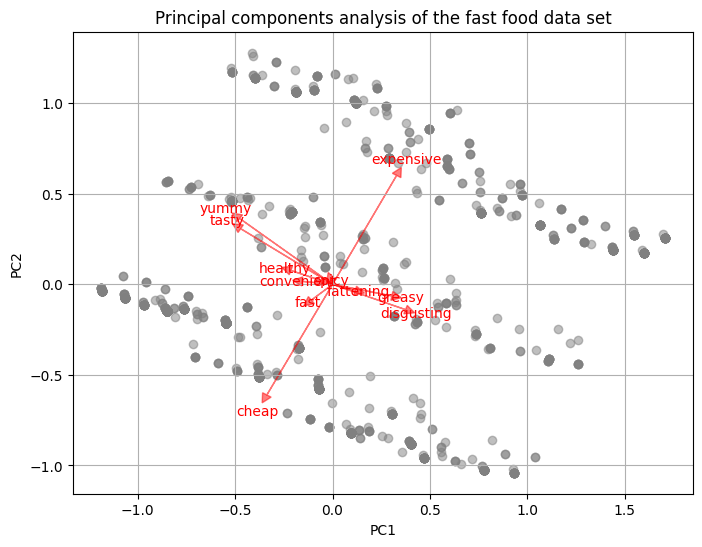

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal components analysis of the fast food data set')

# Function to project axes (principal component loadings)
def projAxes(pca, components=[0, 1]):
    loadings = pca.components_.T[:, components]
    n_features = loadings.shape[0]
    
    for i in range(n_features):
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.5, head_width=0.05, head_length=0.05)
        plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, 
                 data.columns[i], color='red', ha='center', va='center')

# Project the axes
projAxes(pca)

plt.grid(True)
plt.show()

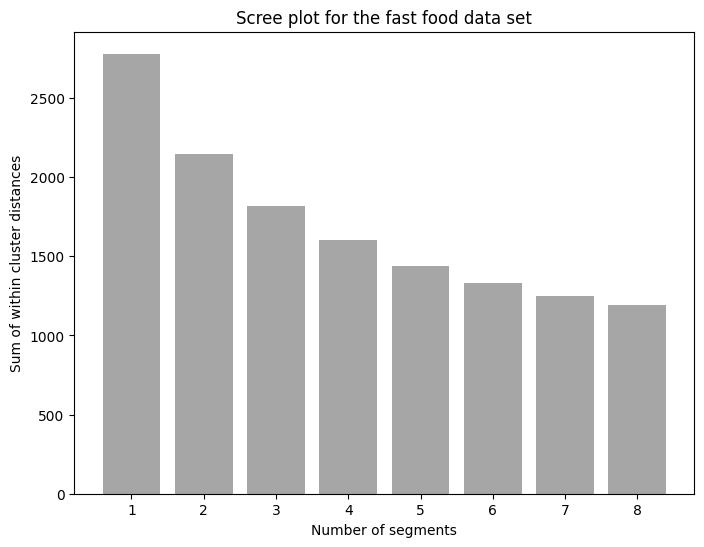

In [11]:
# KMeans clustering
wcss = []
for i in range(1, 9):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.bar(range(1, 9), wcss, color='grey', alpha=0.7)
plt.xlabel('Number of segments')
plt.ylabel('Sum of within cluster distances')
plt.title('Scree plot for the fast food data set')
plt.show()

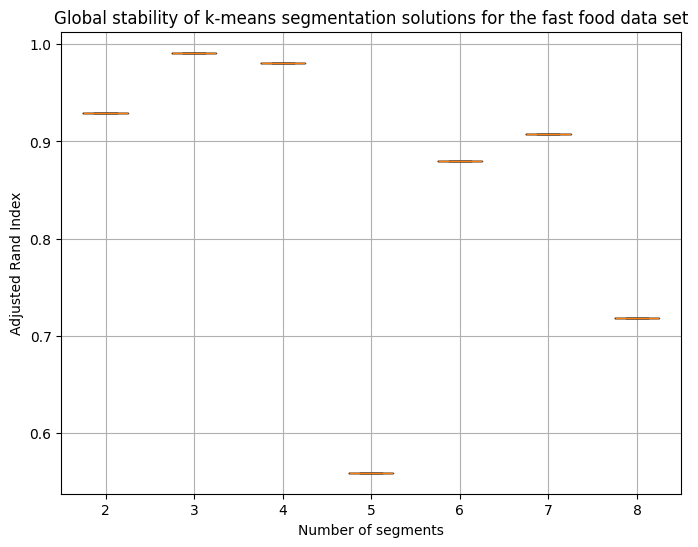

In [14]:
# Set seed for reproducibility
np.random.seed(1234)

# Bootstrapping and calculating ARI
n_clusters_range = range(2, 9)
n_boot = 100
n_rep = 10

ari_scores = {k: [] for k in n_clusters_range}

for k in n_clusters_range:
    for _ in range(n_rep):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_x)
        original_labels = kmeans.labels_
        
        for _ in range(n_boot):
            MD_x_resampled, original_labels_resampled = resample(MD_x, original_labels, random_state=1234)
            kmeans_resampled = KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_x_resampled)
            ari = adjusted_rand_score(original_labels_resampled, kmeans_resampled.labels_)
            ari_scores[k].append(ari)

# Plot the ARI scores
plt.figure(figsize=(8, 6))
plt.boxplot([ari_scores[k] for k in n_clusters_range], labels=n_clusters_range)
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global stability of k-means segmentation solutions for the fast food data set')
plt.grid(True)
plt.show()

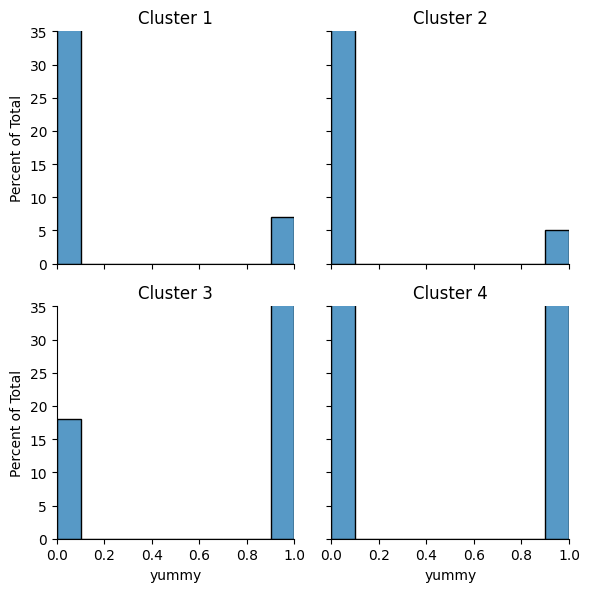

In [15]:
# Perform KMeans clustering with k=4
kmeans = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans.fit(MD_x)
cluster_labels = kmeans.labels_

# Create a DataFrame with cluster labels and data
cluster_data = pd.DataFrame(MD_x)
cluster_data['Cluster'] = cluster_labels

# Define a function to plot histograms of clusters
def plot_histogram(data, **kwargs):
    sns.histplot(data, bins=10, kde=False, **kwargs)
    plt.xlim(0, 1)
    plt.ylim(0, 35)
    plt.xlabel('Similarity')
    plt.ylabel('Percent of Total')

# Use FacetGrid to create subplots for each cluster
g = sns.FacetGrid(cluster_data, col='Cluster', col_wrap=2, sharex=True, sharey=True)
g.map_dataframe(plot_histogram, x='yummy')  # Assuming 'yummy' is the column you want to plot

# Add titles and adjust layout
for ax, title in zip(g.axes.flat, ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']):
    ax.set_title(title)

plt.show()

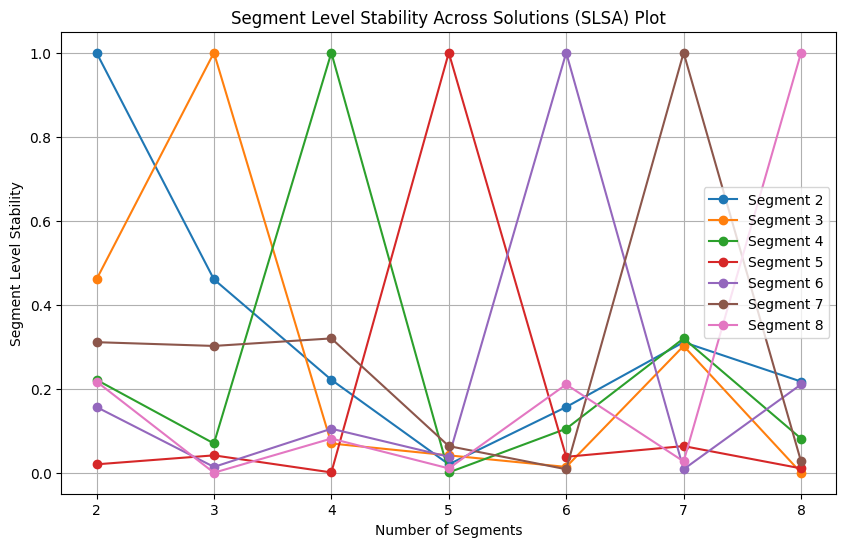

In [16]:
# Perform KMeans clustering for each number of clusters and store labels
num_segments = range(2, 9)
segment_stability = []

for n_clusters in num_segments:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    labels_segment = kmeans.labels_
    segment_stability.append(labels_segment)

# Plotting the Segment Level Stability Across Solutions (SLSA) plot
plt.figure(figsize=(10, 6))

for i, segment in enumerate(num_segments):
    stability = [np.mean(segment_stability[i] == labels) for labels in segment_stability]
    plt.plot(num_segments, stability, marker='o', label=f'Segment {segment}')

plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments)
plt.legend()
plt.grid(True)
plt.show()

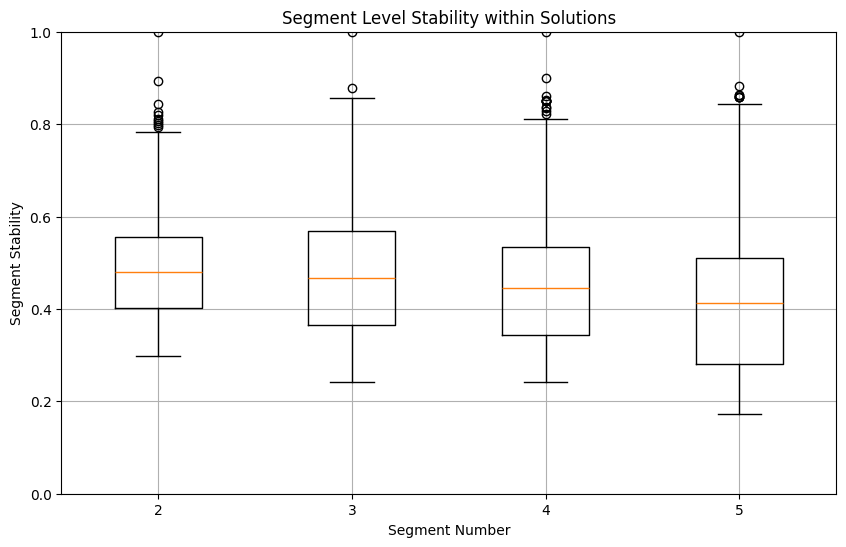

In [17]:
# Perform KMeans clustering for each number of clusters and store models
segment_solutions = ["2", "3", "4", "5"]
kmeans_models = {}
for segment in segment_solutions:
    n_clusters = int(segment)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_models[segment] = kmeans

# Calculate cluster labels and similarities for each segment solution
segment_labels = {}
segment_similarities = {}
for segment in segment_solutions:
    labels = kmeans_models[segment].labels_
    similarities = kmeans_models[segment].transform(MD_x).min(axis=1)
    segment_labels[segment] = labels
    segment_similarities[segment] = similarities

# Calculate normalized segment stability values for each segment solution
segment_stability_values = []
for segment in segment_solutions:
    similarities = segment_similarities[segment]
    normalized_similarities = similarities / np.max(similarities)
    segment_stability_values.append(normalized_similarities)

# Plotting the boxplot for segment stability within solutions
plt.figure(figsize=(10, 6))
plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions)
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")
plt.grid(True)

plt.show()

In [21]:
# Standardize the data
scaler = StandardScaler()
MD_scaled = scaler.fit_transform(MD_x)

# Define the range of number of segments to consider
k_values = range(2, 9)
MD_m28 = []

# Fit Gaussian Mixture Models for each number of components
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=1234, n_init=10)
    gmm.fit(MD_scaled)
    
    # Gather model information
    iter_val = gmm.n_iter_
    converged = gmm.converged_
    k_val = k
    log_likelihood = gmm.lower_bound_
    n_samples, _ = MD_scaled.shape
    aic = gmm.aic(MD_scaled)
    bic = gmm.bic(MD_scaled)
    labels = gmm.predict(MD_scaled)
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy

    MD_m28.append((iter_val, converged, k_val, log_likelihood, aic, bic, icl))

# Create DataFrame to display results
MD_m28 = pd.DataFrame(MD_m28, columns=['iter', 'converged', 'k', 'logLik', 'AIC', 'BIC', 'ICL'])
print(MD_m28)

   iter  converged  k     logLik           AIC           BIC           ICL
0     8       True  2  -4.082019  12172.346138  12990.960916  12990.377185
1    10       True  3   5.015284 -14108.415041 -12877.852182 -12878.925571
2     7       True  4   7.390977 -20856.180542 -19213.669600 -19214.843861
3     7       True  5  10.789272 -30575.623904 -28521.164881 -28522.455540
4    14       True  6  15.964361 -45458.433005 -42992.025901 -42993.534212
5     9       True  7  18.228813 -51882.931092 -49004.575905 -49006.408144
6     8       True  8  18.836477 -53492.802546 -50202.499278 -50204.241310


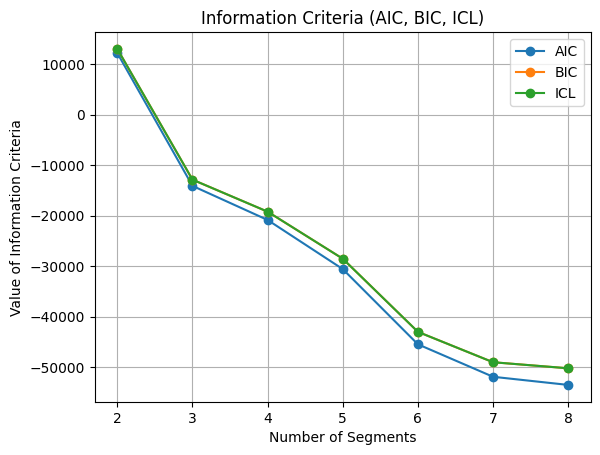

In [22]:
# Plotting the information criteria (AIC, BIC, ICL) for different 'k' values
num_segments = MD_m28["k"]
AIC_values = MD_m28["AIC"]
BIC_values = MD_m28["BIC"]
ICL_values = MD_m28["ICL"]

plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')

plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)

plt.show()

In [23]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans_clusters = kmeans.fit_predict(MD_scaled)

# Fit a Gaussian Mixture Model using the k-means clusters as initial clusters
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(MD_scaled)
gmm_clusters = gmm.predict(MD_scaled)

# Create a contingency table
contingency_table = pd.crosstab(kmeans_clusters, gmm_clusters, rownames=['kmeans'], colnames=['mixture'])
print(contingency_table)

mixture    0    1   2    3
kmeans                    
0        679   11   8   51
1          0  123   0    0
2          0    0  48  217
3          0    0   5  311


In [24]:
gmm_m4a = GaussianMixture(n_components=4, random_state=1234)
gmm_m4a.fit(MD_scaled)
log_likelihood_m4a = gmm_m4a.score(MD_scaled) * MD_scaled.shape[0]

gmm_m4 = GaussianMixture(n_components=4, random_state=1234)
gmm_m4.fit(MD_scaled)
log_likelihood_m4 = gmm_m4.score(MD_scaled) * MD_scaled.shape[0]

print(f'Log Likelihood (m4a): {log_likelihood_m4a:.3f}')
print(f'Log Likelihood (m4): {log_likelihood_m4:.3f}')

Log Likelihood (m4a): 7484.795
Log Likelihood (m4): 7484.795


In [29]:
# Function to extract numeric value from string
def extract_numeric(value):
    match = re.search(r'\d+', value)
    if match:
        return int(match.group())
    else:
        return None

# Apply the function to the 'Like' column
data['Like_numeric'] = data['Like'].apply(extract_numeric)

# Filter out rows where numeric value couldn't be extracted
data1 = data.dropna(subset=['Like_numeric'])

#  Create 'Like.n'
data1['Like.n'] = 6 - data1['Like_numeric']

#  Table of 'Like.n'
like_n_counts = data1['Like.n'].value_counts().sort_index()
print("\nTable of 'Like.n':")
print(like_n_counts)

# Reverse table of 'Like'
like_counts = data1['Like'].value_counts().sort_index(ascending=False)
print("Reverse table of 'Like':")
print(like_counts)


Table of 'Like.n':
Like.n
1    295
2    231
3    302
4    246
5    210
6    169
Name: count, dtype: int64
Reverse table of 'Like':
Like
I love it!+5    143
I hate it!-5    152
0               169
-4               71
-3               73
-2               59
-1               58
+4              160
+3              229
+2              187
+1              152
Name: count, dtype: int64


In [32]:
from patsy import dmatrices, dmatrix

independent_vars = data.columns[0:11]

formula_str = ' + '.join(independent_vars)

formula_str = 'Like ~ ' + formula_str


f = dmatrices(formula_str, data=data)[1]

print(f)

[[1. 0. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]]


In [33]:
X = dmatrix(f.design_info, data=data)

#  Fit GaussianMixture model with n_components=2 on the design matrix 'X'
n_components = 2
n_init = 10
verbose = False
n_rep = 10
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=verbose)
MD_reg2 = model.fit(X)

#  Print the GaussianMixture model after fitting
print(MD_reg2)

# Step 25: Calculate and print the sizes of each cluster in the GaussianMixture model
cluster_sizes = np.bincount(model.predict(X))
print("Cluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"{i+1}: {size}")

GaussianMixture(n_components=2, n_init=10, verbose=False)
Cluster sizes:
1: 985
2: 468


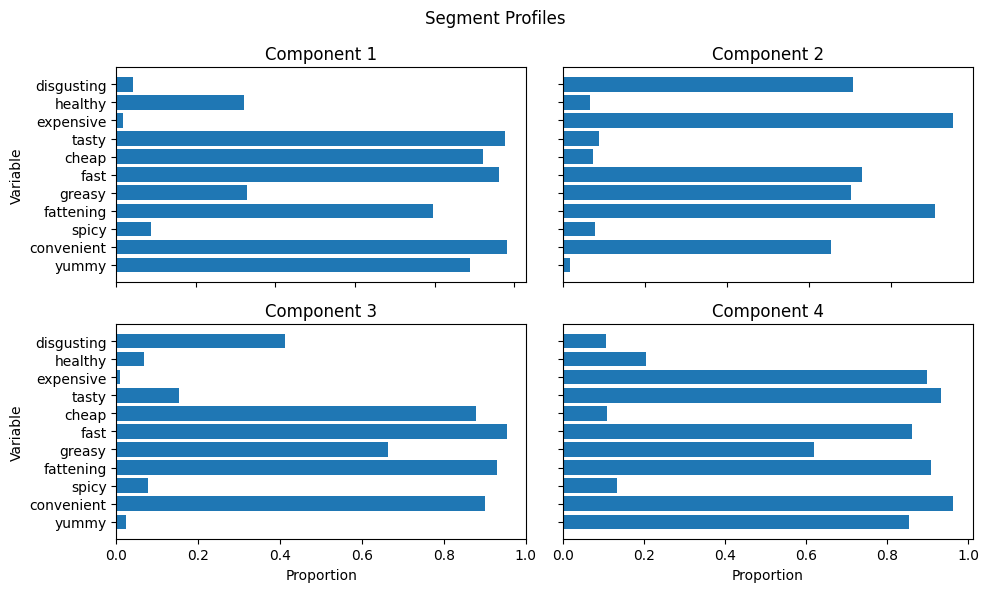

In [36]:
MD_km28 = {'4': KMeans(n_clusters=4, random_state=1234).fit(MD_x)}
# Assuming 'MD_km28' has 28 columns, and '4' is one of the columns representing the cluster labels
kmeans = MD_km28['4']
labels = kmeans.labels_

# Group the data by cluster labels and calculate the mean for each cluster
MD_mean = MD_x.groupby(labels).mean()

# Create a 2x2 subplots figure to display the bar plots of the cluster profiles
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot the bar plots for each component (1 to 4) in separate subplots
axs[0, 0].barh(range(MD_mean.shape[1]), MD_mean.iloc[0])
axs[0, 0].set_title('Component 1')
axs[0, 1].barh(range(MD_mean.shape[1]), MD_mean.iloc[1])
axs[0, 1].set_title('Component 2')
axs[1, 0].barh(range(MD_mean.shape[1]), MD_mean.iloc[2])
axs[1, 0].set_title('Component 3')
axs[1, 1].barh(range(MD_mean.shape[1]), MD_mean.iloc[3])
axs[1, 1].set_title('Component 4')

# Set labels and ticks for each subplot
for ax in axs.flat:
    ax.set(ylabel='Variable', xlabel='Proportion')
    ax.set_yticks(range(MD_mean.shape[1]))
    ax.set_yticklabels(MD_x.columns)

# Hide the x-labels and y-labels of inner subplots to avoid overlap
for ax in axs.flat:
    ax.label_outer()

# Add the overall title and adjust the layout
fig.suptitle('Segment Profiles')
fig.tight_layout()

# Show the plot
plt.show()

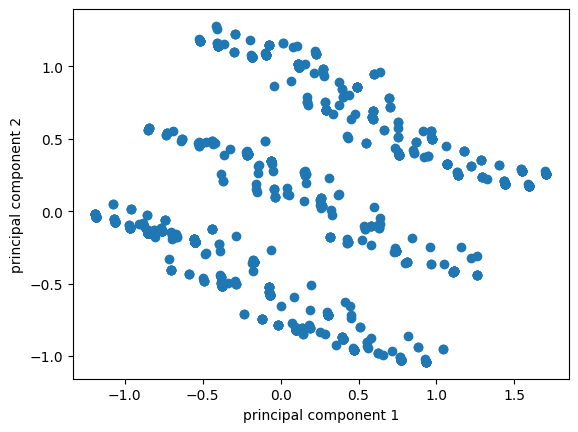

In [37]:
# Create a KMeans object with 4 clusters and fit it to 'MD_x'
kmeans = KMeans(n_clusters=4)
kmeans.fit(MD_x)

# Perform PCA with 2 components on 'MD'
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

# Create a scatter plot to visualize the data points in the reduced 2D space
fig, ax = plt.subplots()
ax.scatter(MD_pca[:, 0], MD_pca[:, 1])
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

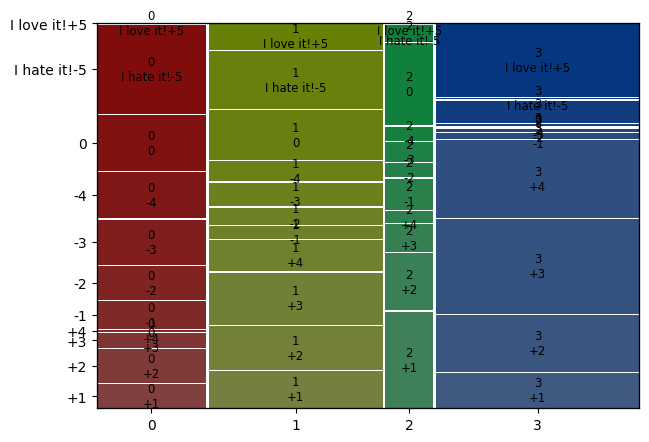

In [40]:
# Perform KMeans clustering with 4 clusters on the categorical data
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(MD_x)

# Add a new column 'cluster_num' to 'data1' containing the cluster labels
data1['cluster_num'] = kmeans.labels_

# Create a cross-tabulation between 'cluster_num' and 'Like' columns
crosstab = pd.crosstab(data1['cluster_num'], data1['Like'])

# Reordering columns for better visualization
# crosstab = crosstab[['I hate it!-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', 'I love it!+5']]

# Create a mosaic plot to visualize the relationship between 'cluster_num' and 'Like'
plt.rcParams['figure.figsize'] = (7, 5)
mosaic(crosstab.stack())
plt.show()

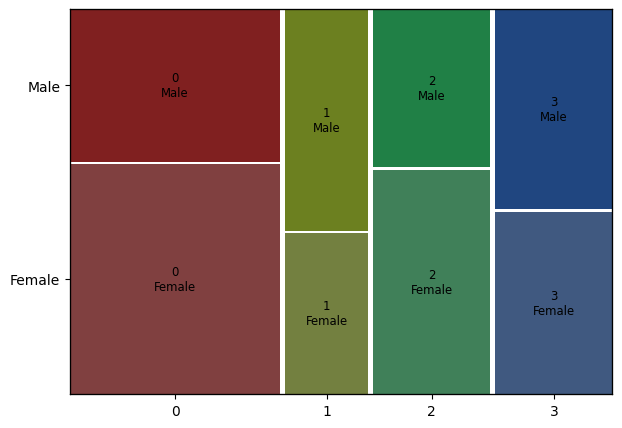

In [41]:
MD_k4 = MD_km28['4']

# Get the cluster labels from 'MD_k4'
k4 = MD_k4.labels_

# Create a cross-tabulation (contingency table) between the cluster labels 'k4' and the 'Gender' column in the 'data' DataFrame
ct = pd.crosstab(k4, data1['Gender'])

# Visualize the cross-tabulation using a mosaic plot
mosaic(ct.stack(), gap=0.01)

# Show the plot
plt.show()

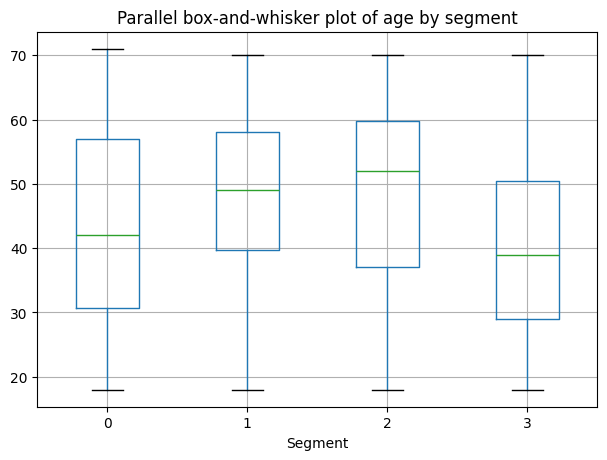

In [42]:
# Create a new DataFrame 'df' with 'Segment' and 'Age' columns from the original dataset 'data'.
df1 = pd.DataFrame({'Segment': k4, 'Age': data1['Age']})

# Generate a box-and-whisker plot of 'Age' grouped by 'Segment'.
df1.boxplot(by='Segment', column='Age')
plt.title('Parallel box-and-whisker plot of age by segment')
plt.suptitle('')
plt.show()